In [1]:
import warnings

warnings.filterwarnings("ignore")

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import seaborn as sns
from math import sqrt
from scipy.sparse import csr_matrix
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from scipy.sparse import lil_matrix, save_npz, load_npz
from typing import List, Dict
from tqdm import tqdm
import implicit
import ast

sns.set_style("whitegrid")


In [2]:
train = pd.read_csv('train_10k.csv')
test = pd.read_csv('test_10k.csv')

In [3]:
train

,user_id,song_id,play_count,title,release,artist_name,year,genre,artist_country,artist_city
0,6fbf6970611d01e10aebeab374f461116155867e,SOPVPCY12A81C23555,1,Unlove You (Album Version),Headstrong,Ashley Tisdale,2007,pop_rock,United States,Ocean Township
1,fa8a8753518e6c2d3713990dc2a172ea17000b80,SOBSMEQ12AB018282F,1,Towards The Sun,Away We Go Original Motion Picture Soundtrack,Alexi Murdoch,2009,soundtrack,United Kingdom,London
2,c9fdf63587a7a963e383ea2f1b58d1014377caab,SONQEYS12AF72AABC9,1,Mr. Jones,Films About Ghosts (The Best Of Counting Crows),Counting Crows,1991,rock,United States,Berkeley
3,e329cc2012d31242297d294fa0279b79a1bd5cc7,SOHTAXD12A8C141E75,1,Scratch Tail,Collide,Beats Antique,2008,electronic,United States,Oakland
4,2a9178398fa6377a340d5b9b6be87de32b4059a2,SOAWWJW12AB01814F5,2,Don't Haunt This Place,Hometowns,The Rural Alberta Advantage,2008,rock,Canada,Toronto
...,...,...,...,...,...,...,...,...,...,...
682423,68e6239baf3b9ff00a2604dff7b862ab23c5c6af,SOSZRKV12AB017EB5B,1,Girl Goes To Show,One Eye To Morocco,Ian Gillan,2009,rock,United Kingdom,Hounslow
682424,e4162d3e1e7e02b161bde4bee62ac553bb5c75d4,SOBBKGF12A8C1311EE,4,Where Is My Mind?,Wave Of Mutilation: Best Of Pixies,Pixies,1988,singles,United States,Boston
682425,f6ddc01926ec302ef9eb49f9ae1442e8e85e8025,SORPDDI12AB0189077,3,Where You Are,Feels Like Today,Rascal Flatts,2004,country,United States,Columbus
682426,ea6feef98a3344396da7b8c3dfc516c6e7a38cd1,SOWEUOO12A6D4F6D0C,1,Given Up (Album Version),Minutes To Midnight,Linkin Park,2007,kategorien,United States,Agoura Hills


# Map user_id and song_id with ordinary increasing sequence

In [5]:
with open("users_10k_id_for_sparse.txt") as f:
    lines = f.readlines()
m = lines[0]
users_dict = ast.literal_eval(m)


In [6]:
len(users_dict)

10000

In [7]:
with open("songs_10k_id_for_sparse.txt") as f:
    lines = f.readlines()
m = lines[0]
song_dict = ast.literal_eval(m)


In [8]:
len(song_dict)

88058

In [9]:
train["user_id"] = train["user_id"].map(users_dict)

In [10]:
train["song_id"] = train["song_id"].map(song_dict)

In [11]:
test["user_id"] = test["user_id"].map(users_dict)
test["song_id"] = test["song_id"].map(song_dict)

In [13]:
train

,user_id,song_id,play_count,title,release,artist_name,year,genre,artist_country,artist_city
0,4337,55701,1,Unlove You (Album Version),Headstrong,Ashley Tisdale,2007,pop_rock,United States,Ocean Township
1,9767,6227,1,Towards The Sun,Away We Go Original Motion Picture Soundtrack,Alexi Murdoch,2009,soundtrack,United Kingdom,London
2,7908,48367,1,Mr. Jones,Films About Ghosts (The Best Of Counting Crows),Counting Crows,1991,rock,United States,Berkeley
3,8867,28004,1,Scratch Tail,Collide,Beats Antique,2008,electronic,United States,Oakland
4,1625,3134,2,Don't Haunt This Place,Hometowns,The Rural Alberta Advantage,2008,rock,Canada,Toronto
...,...,...,...,...,...,...,...,...,...,...
682423,4088,66009,1,Girl Goes To Show,One Eye To Morocco,Ian Gillan,2009,rock,United Kingdom,Hounslow
682424,8896,3778,4,Where Is My Mind?,Wave Of Mutilation: Best Of Pixies,Pixies,1988,singles,United States,Boston
682425,9612,61461,3,Where You Are,Feels Like Today,Rascal Flatts,2004,country,United States,Columbus
682426,9128,76258,1,Given Up (Album Version),Minutes To Midnight,Linkin Park,2007,kategorien,United States,Agoura Hills


In [14]:
test

,user_id,song_id,play_count,title,release,artist_name,year,genre,artist_country,artist_city
0,1234,11506,4,You Appearing,Saturdays = Youth,M83,2008,electronic,France,Antibes
1,6261,56945,1,The Old Homestead (Remastered Album Version),Hawks & Doves,Neil Young,1980,rock,Canada,Toronto
2,9153,85415,2,One,...And Justice For All,Metallica,1988,rock,United States,Los Angeles
3,8483,87056,1,Tú,Shakira MTV Unplugged,Shakira,1998,pop,Colombia,Barranquilla
4,8246,69701,1,Hustla Balla Gangsta Mack,Rich Boy,Rich Boy,2007,hiphop,United States,Mobile
...,...,...,...,...,...,...,...,...,...,...
170602,8176,70411,1,Goodbye,Goodbye,Kristinia DeBarge,2009,pop,United States,South Pasadena
170603,5408,61673,1,Da Bump,Muddy Waters,Redman,1996,hiphop,United States,Newark
170604,6062,40013,1,Love Deep Inside,Love Deep Inside,Rico Bernasconi,2009,dance,Germany,Menden (Sauerland)
170605,1356,23834,1,Out Of Your Life,Poison Years,Bob Mould,1990,rock,United States,Malone


In [15]:
user_encoder = LabelEncoder()
item_encoder = LabelEncoder()

train["user_id"] = user_encoder.fit_transform(train["user_id"])
train["song_id"] = item_encoder.fit_transform(train["song_id"])

num_users, num_songs = train.user_id.nunique(), train.song_id.nunique()
num_users, num_songs


(10000, 81458)

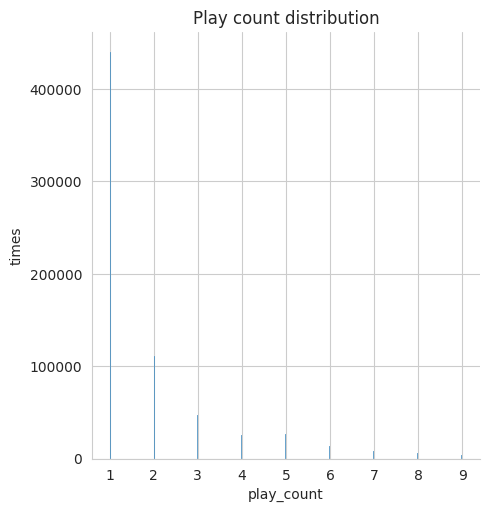

In [21]:
fig = sns.displot(train.play_count).set(title="Play count distribution")
fig.set_axis_labels("play_count", "times")


# Alternating Least Square

In [101]:
train_sparce = load_npz('train_10k_sparse_matrix.npz')

In [121]:
def ALS(sp, user, items, ratings, num_users, num_songs, dim=64, n_iters=5, eps=1e-7):
    # Sparce matrix for item-user data
    R = sp
    print(R.shape)
    # User matrix
    P = np.random.randn(num_users, dim)
    # Item matrix
    Q = np.random.randn(num_songs, dim)

    # Make real matrix decomposition
    for t in tqdm(range(n_iters)):
        RQ = R @ Q
        for u in range(num_users):
            relevant_items = items[users == u]
            Q_rel = Q[relevant_items]
            QQ = Q_rel.reshape(-1, dim, 1) * Q_rel.reshape(-1, 1, dim)
            P[u] = np.linalg.inv(QQ.sum(axis=0) + eps * np.eye(dim)) @ RQ[u]

        RP = R.T @ P
        for i in range(num_songs):
            relevant_users = users[items == i]
            P_rel = P[relevant_users]
            PP = P_rel.reshape(-1, dim, 1) * P_rel.reshape(-1, 1, dim)
            Q[i] = np.linalg.inv(PP.sum(axis=0) + eps * np.eye(dim)) @ RP[i]

    return P, Q


In [23]:
P, Q = ALS(
    train_sparce,
    train.user_id,
    train.song_id,
    train.play_count,
    num_users,
    num_songs,
    n_iters=10,
)


(10000, 81458)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [22:56<00:00, 275.32s/it]


In [24]:
#
def remove_train_items(preds, k):
    new_preds = np.zeros((preds.shape[0], k), dtype=np.int)
    for user, data in train.groupby("user_id"):
        user_preds = preds[user]
        new_preds[user] = user_preds[~np.in1d(user_preds, data.song_id)][:k]
    return new_preds


def get_ALS_preds(U, V, k):
    preds = np.argsort(U @ V.T, axis=1)
    preds = remove_train_items(preds, k)
    return preds


# different random songs for each user
def get_random_preds(k):
    preds = np.tile(np.arange(num_songs), (num_users, 1))
    for i in range(num_users):
        rand_perm = np.random.permutation(num_songs)
        preds[i] = preds[i][rand_perm]

    preds = remove_train_items(preds, k)
    return preds


# predict with framework
def get_implicit_pred(k):
    item_user_data = load_npz("train_10k_sparse_matrix.npz")
    model = implicit.als.AlternatingLeastSquares(factors=50)
    model.fit(item_user_data)
    implicit_pred = []
    for i in range(num_users):
        recommendations = model.recommend(i, user_items[i], N=k)[0]
        implicit_pred.append(recommendations)
    return implicit_pred


# the same top songs for each user
def get_toppop_preds(freq, k):
    mean_rating = train.groupby("song_id").play_count.mean()
    mean_rating = mean_rating[train.groupby("song_id").size() >= freq]
    preds = np.array(mean_rating.sort_values(ascending=False).index)
    preds = np.tile(preds, (num_users, 1))
    preds = remove_train_items(preds, k)
    return preds


In [ ]:
def MAP_k(true, pred, k):
    m = 0
    num = min(len(true), len(pred))
    for tr, pr in zip(true, pred):
        if not tr:
            continue
        tr_in_pr = np.isin(pr[:k], tr)
        m += (tr_in_pr / np.arange(1, k + 1)).sum() / (
            1 / np.arange(1, len(tr) + 1)
        ).sum()
    m = m / num
    return m


In [34]:
true_relevant = []
for user, song in test[test.play_count > 3].groupby("user_id"):
    true_relevant += [song.song_id.tolist()]


In [36]:
ks = np.arange(1, 31)
als_preds = get_ALS_preds(P, Q, k=ks[-1])
random_preds = get_random_preds(k=ks[-1])
top_preds = get_toppop_preds(freq=10, k=ks[-1])
implicit_pred = get_implicit_pred(k=ks[-1])

random_map_k = [MAP_k(true_relevant, random_preds, k=k) for k in ks]
top_map_k = [MAP_k(true_relevant, top_preds, k=k) for k in ks]
als_map_k = [MAP_k(true_relevant, als_preds, k=k) for k in ks]
impl_map_k = [MAP_k(true_relevant, implicit_pred, k=k) for k in ks]


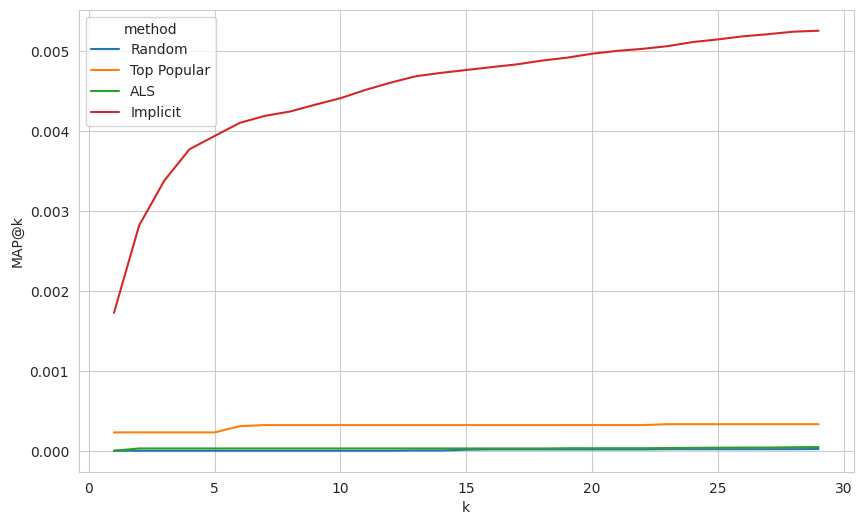

In [155]:
plt.figure(figsize=(10, 6))
plt.plot(ks, random_map_k, label="Random")
plt.plot(ks, top_map_k, label="Top Popular")
plt.plot(ks, als_map_k, label="ALS")
plt.plot(ks, impl_map_k, label="Implicit")

plt.legend(title="method")
plt.xlabel("k")
plt.ylabel("MAP@k")
plt.show()


In [30]:
def AR_k(true, pred, k):

    if not true:
        return 0.0

    if len(pred) > k:
        pred = pred[:k]

    score = 0.0
    hits = 0.0

    for i, p in enumerate(pred):
        if p in true and p not in pred[:i]:
            hits += 1.0
            score += hits / (i + 1.0)

    return score / len(true)


def MAR_k(true, pred, k):

    return np.mean([AR_k(a, p, k) for a, p in zip(true, pred)])


In [156]:
random_map_k = [MAR_k(true_relevant, random_preds, k=k) for k in ks]
top_map_k = [MAR_k(true_relevant, top_preds, k=k) for k in ks]
als_map_k = [MAR_k(true_relevant, als_preds, k=k) for k in ks]
impl_map_k = [MAR_k(true_relevant, implicit_pred, k=k) for k in ks]


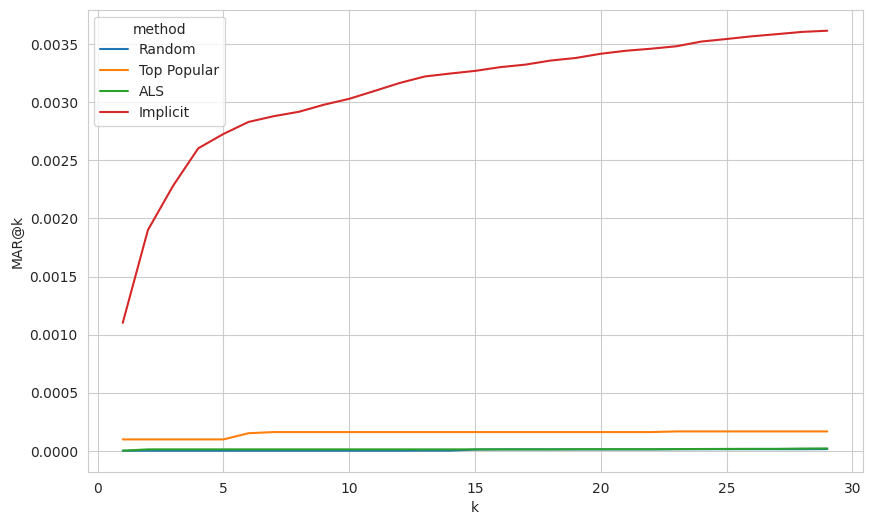

In [157]:
plt.figure(figsize=(10, 6))
plt.plot(ks, random_map_k, label='Random')
plt.plot(ks, top_map_k, label='Top Popular')
plt.plot(ks, als_map_k, label='ALS')
plt.plot(ks, impl_map_k, label='Implicit')

plt.legend(title='method')
plt.xlabel('k')
plt.ylabel('MAR@k')
plt.show()